In [1]:
import cv2
import numpy as np
from matplotlib import pyplot
import pickle as pkl
from tensorflow import keras
from keras import Model
from keras.layers import Dense, Flatten
from keras.callbacks import EarlyStopping, Callback

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Images Generators

In [22]:
!cp /content/drive/MyDrive/102flowers/data1.zip /content/data1.zip

In [ ]:
!unzip /content/data1.zip

In [70]:
with open("/content/drive/MyDrive/102flowers/pkl-1/X_train.pkl", "rb") as f:
  X_train = pkl.load(f)
with open("/content/drive/MyDrive/102flowers/pkl-1/y_train.pkl", "rb") as f:
  y_train = pkl.load(f)

train_imgs = []
for i, path in enumerate(X_train):
  img = path.split('\\')[-1]
  train_imgs.append(f"/content/train/{y_train[i]}/{img}")

In [71]:
with open("/content/drive/MyDrive/102flowers/pkl-1/X_val.pkl", "rb") as f:
  X_val = pkl.load(f)
with open("/content/drive/MyDrive/102flowers/pkl-1/y_val.pkl", "rb") as f:
  y_val = pkl.load(f)

val_imgs = []
for i, path in enumerate(X_val):
  img = path.split('\\')[-1]
  val_imgs.append(f"/content/val/{y_val[i]}/{img}")

In [72]:
with open("/content/drive/MyDrive/102flowers/pkl-1/X_test.pkl", "rb") as f:
  X_test = pkl.load(f)
with open("/content/drive/MyDrive/102flowers/pkl-1/y_test.pkl", "rb") as f:
  y_test = pkl.load(f)

test_imgs = []
for i, path in enumerate(X_test):
  img = path.split('\\')[-1]
  test_imgs.append(f"/content/test/{y_test[i]}/{img}")

I will implement a generator class, instead of loading all the data to RAM.

In [73]:
class FlowersImagesGenerator(keras.utils.Sequence):

  def __init__(self, images_paths, y, num_classes=102, batch_size=32, *args, **kwargs):
    self.images_paths = images_paths
    self.y = y
    self.num_classes = num_classes
    self.batch_size = batch_size

  def __len__(self):
    return (len(self.images_paths) // self.batch_size)

  def __getitem__(self, index):
    batch_images = self.images_paths[self.batch_size*index : self.batch_size*(index+1)]
    y_batch = self.y[self.batch_size*index : self.batch_size*(index+1)]

    X = [cv2.resize(cv2.imread(img_path)/255, (256,256)) for img_path in batch_images]
    y_onehot = np.zeros((y_batch.shape[0], self.num_classes))
    for i, val in enumerate(y_batch):
      y_onehot[i, val - 1] = 1  # y classes are 1 to 102
    return np.array(X), y_onehot

In [74]:
num_classes = 102

# VGG19

In [75]:
vgg19 = keras.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3),
    classes=num_classes,
    classifier_activation='softmax')

In [76]:
for layer in vgg19.layers:
  layer.trainable = False

In [77]:
out = Flatten()(vgg19.output)
out = Dense(4096, activation='relu', name="fc1")(out)
out = Dense(4096, activation='relu', name="fc2")(out)
predictions = Dense(num_classes, activation='softmax', name="predictions")(out)
model = Model(inputs=vgg19.input, outputs=predictions)

In [78]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [79]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy', 'categorical_accuracy'])

I will create a custom callback for logging the accuracy and loss on the test set in each epoch, as the instructions specify.  


In [80]:
class TestMetricsCallback(Callback):
  def __init__(self):
    self.epoch_test_loss = []
    self.epoch_test_accuracy = []
    self.epoch_test_categorical_accuracy = []

  def on_epoch_end(self, epoch, logs=None):
    test_generator = FlowersImagesGenerator(images_paths=test_imgs, y=y_test)
    loss, accuracy, categorical_accuracy = self.model.evaluate(test_generator)
    self.epoch_test_loss.append(loss)
    self.epoch_test_accuracy.append(accuracy)
    self.epoch_test_categorical_accuracy.append(categorical_accuracy)

In [81]:
train_generator = FlowersImagesGenerator(images_paths=train_imgs, y=y_train)
val_generator = FlowersImagesGenerator(images_paths=val_imgs, y=y_val)

In [82]:
early_stop_callback = EarlyStopping(monitor='val_loss', mode='min')
test_metrics_callback = TestMetricsCallback()
history = model.fit(train_generator, validation_data=val_generator, epochs=50,
                    callbacks=[test_metrics_callback], verbose=2)

Epoch 1/50
64/64 [==============================] - 18s 280ms/step - loss: 2.5724 - accuracy: 0.3271 - categorical_accuracy: 0.3271
127/127 - 79s - loss: 5.5809 - accuracy: 0.1737 - categorical_accuracy: 0.1737 - val_loss: 2.5028 - val_accuracy: 0.3383 - val_categorical_accuracy: 0.3383 - 79s/epoch - 622ms/step
Epoch 2/50
64/64 [==============================] - 19s 295ms/step - loss: 1.6794 - accuracy: 0.5386 - categorical_accuracy: 0.5386
127/127 - 74s - loss: 1.7093 - accuracy: 0.5322 - categorical_accuracy: 0.5322 - val_loss: 1.6451 - val_accuracy: 0.5456 - val_categorical_accuracy: 0.5456 - 74s/epoch - 585ms/step
Epoch 3/50
64/64 [==============================] - 18s 279ms/step - loss: 1.7733 - accuracy: 0.5371 - categorical_accuracy: 0.5371
127/127 - 72s - loss: 0.7283 - accuracy: 0.7889 - categorical_accuracy: 0.7889 - val_loss: 1.7783 - val_accuracy: 0.5327 - val_categorical_accuracy: 0.5327 - 72s/epoch - 568ms/step
Epoch 4/50
64/64 [==============================] - 18s 278ms

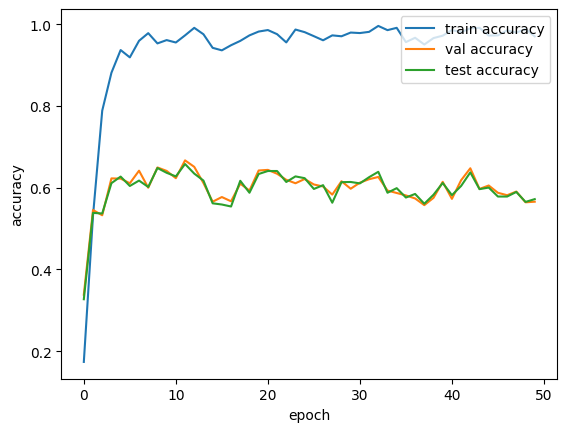

In [83]:
pyplot.plot(history.history['accuracy'], label='train accuracy')
pyplot.plot(history.history['val_accuracy'], label='val accuracy')
pyplot.plot(test_metrics_callback.epoch_test_accuracy, label='test accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(loc="upper right")
pyplot.show()

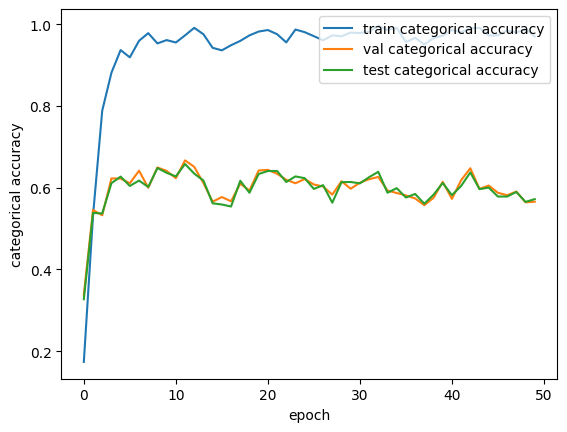

In [84]:
pyplot.plot(history.history['categorical_accuracy'], label='train categorical accuracy')
pyplot.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
pyplot.plot(test_metrics_callback.epoch_test_categorical_accuracy, label='test categorical accuracy')
pyplot.ylabel('categorical accuracy')
pyplot.xlabel('epoch')
pyplot.legend(loc="upper right")
pyplot.show()

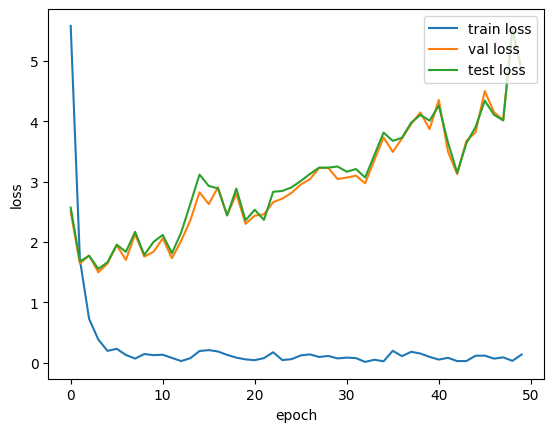

In [85]:
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='val loss')
pyplot.plot(test_metrics_callback.epoch_test_loss, label='test loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(loc="upper right")
pyplot.show()